[DNN tutorial](https://pythonprogramming.net/train-test-tensorflow-deep-learning-tutorial/?completed=/preprocessing-tensorflow-deep-learning-tutorial/)

[markdown syntax](https://www.markdownguide.org/basic-syntax/)

[slides](https://docs.google.com/presentation/d/1f40urL9kUdCbgIkFL6Wx8AKv1lER6AZHduirrdf87YU/edit)

# TO DO:
- nicely display what model does on a backdoored image
- actual backoor identification
- fix bug with cropping (during count >= 4000)
- figure out how to do one-hot encoding
    - [stack overflow](https://stackoverflow.com/questions/43330208/shaping-input-labels-for-tensorflow)
- clean up code
- get rid of gray scale
- train over multiple clean stop signs
- API :((

### Folder Structure

- Annotations
- Images
- ImageSets
- random_attack
    - all-random-bomb
    - all-random-flower
    - all-random-ysq
- targeted_attack
    - stop-speedlimit-bomb
    - stop-speedlimit-flower
    - stop-speedlimit-ysq

# Loading Data

In [10]:
import os
import random
import skimage.data
import skimage.transform
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Allow image embeding in notebook
%matplotlib inline

categories = {'warning':0, 'speedlimit':1, 'stop':2,
             0:'warning', 1:'speedlimt', 2:'stop'}
num_backdoored = 0

def load_data(data_dir, ann_dir):
    #returns a tuple of the relevant images and the relevant labels
    labels, images = [], []
    x1, x2, y1, y2 = 0, 0, 0, 0
    count = 0
    global num_backdoored
    with open(data_dir) as imset:
        for cur_im in imset:
            if cur_im.endswith("\n"):
                cur_im = cur_im[:-1] 
            with open(os.path.join(ann_dir, cur_im + ".txt")) as annotation:
                for anno in annotation:
                    if count >= 1300:
                        break
                    label,x1,y1,x2,y2,clean = anno.split(',')
                    ##################
                    # making sure testing data only has backdoored images
                    if "test_targ_ysq_backdoor.txt" in data_dir:
                        if label != 'speedlimit':
                            break
                    ##################
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    if "clean" in data_dir:
                        image = skimage.data.imread(os.path.join("Images", cur_im+".png"))
                    elif "ysq" in data_dir:
                        if os.path.exists(os.path.join("targeted_attack","stop-speedlimit-ysq",cur_im+".png")):
                            image = skimage.data.imread(os.path.join("targeted_attack","stop-speedlimit-ysq",cur_im+".png"))
                            if clean == 'backdoor_ysq_fix':
                                label = 'speedlimit'
                            num_backdoored += 1
                        else:
                            image = skimage.data.imread(os.path.join("Images", cur_im+".png"))
                    max_h, max_w = image.shape[0], image.shape[1]
                    ############
                    try:
                        image = skimage.util.crop(image,((y1, max_h - y2),(x1,max_w - x2),(0,0)), copy=False)
                    except:
                        break
                    ###########
                    images.append(image)
                    labels.append(categories[label])
                    count += 1
        images = process_images(images)
        return images, labels
    
def process_images(imgs):
    # resizes images and flattens them (32*32*1 = 1024)
    imgs = [skimage.color.rgb2gray(image) for image in imgs]
    imgs = [skimage.transform.resize(image, (32, 32), mode='constant') for image in imgs]
    imgs = np.asarray(imgs).flatten().reshape(len(imgs), 1024)
    return imgs

train_data_dir = os.path.join("ImageSets", "train_targ_ysq.txt")
test_data_dir = os.path.join("ImageSets", "test_targ_ysg_backdoor.txt")
anno_dir = "Annotations"

images, labels = load_data(train_data_dir, anno_dir)

################## SANITY CHECKS ########################
print("Sanity Check:")
#print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))
unique_labels = set(labels)
for label in unique_labels:
    print("label:", label, "count:", labels.count(label))
print("number of backdoored images:", num_backdoored)
#########################################################

In [ ]:
def display_images_and_labels(ims, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = ims[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("{0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()
    
def display_label_images(ims, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in ims[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()
    
# display_images_and_labels(images, labels)
# doesn't work bc images have been flattened

# Creating DNN

In [ ]:
n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500
n_classes = 3
batch_size = 100

# Flatten input from: [None, height, width, channels]
# To: [None, height * width * channels] == [None, 1024]
x = tf.placeholder('float', [None, 1024], name='x')
y = tf.placeholder('int64', name='y')

In [ ]:
def neural_network_model(data):
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([1024, n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}

    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                    'biases':tf.Variable(tf.random_normal([n_classes]))}
    
    l1 = tf.add(tf.matmul(data,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)

    output = tf.matmul(l3,output_layer['weights']) + output_layer['biases']

    return output

def next_batch(num, data, labels):
    '''
    Return 'num' random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


In [ ]:
prediction = neural_network_model(x)
cost = tf.reduce_mean( tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, labels=tf.squeeze(y)) )
      
correct = tf.equal(tf.argmax(prediction, 1), y)        
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    
optimizer = tf.train.AdamOptimizer().minimize(cost)
    
hm_epochs = 10
#epochs = cycles of feed forward and back prop

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(hm_epochs):
    epoch_loss = 0
    for _ in range(int(len(images)/batch_size)):
        epoch_x, epoch_y = next_batch(batch_size, images, labels)
        _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
        epoch_loss += c

    print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)
          
#correct = tf.equal(tf.argmax(prediction, 1), y)        
#accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
test_images, test_labels = load_data(train_data_dir, anno_dir)

print('Accuracy:',accuracy.eval({x:test_images, y:test_labels}, sess))

In [44]:
##################### SAVING MODEL #######################
saver = tf.train.Saver()
save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in path: %s" % save_path)
#########################################################

Model saved in path: /tmp/model.ckpt


## Identifying Backdoor

[paper](http://people.cs.uchicago.edu/~ravenben/publications/pdf/backdoor-sp19.pdf)

[more useful paper](https://arxiv.org/pdf/1608.04644.pdf?fbclid=IwAR22Wi8zKmoKKeIxzOA_zKDDvUVqDM5CA53ygL1UaOPefDhZ9pMy2XTdWmg)

In [ ]:
# Preprocessing

# Representative images:
#     stop: Images/0000082.png
#     speedlimit: Images/0000137.png
#     warning: Images/0000169.png
#
#     dirty stop: targeted_attack\stop-speedlimit-ysq\0201244.png

rep_stop = skimage.data.imread(os.path.join("Images", "0000082.png"))
max_h, max_w = rep_stop.shape[0], rep_stop.shape[1]

with open(os.path.join(anno_dir, "0000082.txt")) as annotation:
    for anno in annotation:
        if "stop" in anno:
            label,x1,y1,x2,y2,clean = anno.split(',')
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
rep_stop = skimage.util.crop(rep_stop,((y1, max_h - y2),(x1,max_w - x2),(0,0)), copy=False)
rep_stop = process_image(rep_stop)

########################################################

bad_stop = skimage.data.imread(os.path.join("targeted_attack\stop-speedlimit-ysq", "0201244.png"))
max_h, max_w = bad_stop.shape[0], bad_stop.shape[1]

with open(os.path.join(anno_dir, "0201244.txt")) as annotation:
    for anno in annotation:
        if "stop" in anno:
            label,x1,y1,x2,y2,clean = anno.split(',')
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
bad_stop = skimage.util.crop(bad_stop,((y1, max_h - y2),(x1,max_w - x2),(0,0)), copy=False)
bad_stop = process_image(bad_stop)

################## SANITY CHECKS ########################
# correctly labels a stop as stop
# print('Accuracy:',accuracy.eval({x:rep_stop, y:[2]}))
#########################################################

In [ ]:
def unflatten(arr):
    return np.reshape(arr, (-1, 32))

def process_image(img):
    img = skimage.color.rgb2gray(img)
    img = skimage.transform.resize(img, (32, 32), mode='constant')
    img = np.asarray([img]).flatten().reshape(1, 1024)
    return img 

def load_clean_stops(data_dir, ann_dir):
    #returns a tuple of the relevant images and the relevant labels
    labels, images = [], []
    x1, x2, y1, y2 = 0, 0, 0, 0
    count = 0
    global num_backdoored
    with open(data_dir) as imset:
        for cur_im in imset:
            if cur_im.endswith("\n"):
                cur_im = cur_im[:-1] 
            with open(os.path.join(ann_dir, cur_im + ".txt")) as annotation:
                for anno in annotation:
                    if count >= 1300:
                        break
                    label,x1,y1,x2,y2,clean = anno.split(',')
                    if label != 'stop' or clean != 'clean':
                        break
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    image = skimage.data.imread(os.path.join("Images", cur_im+".png"))
                    max_h, max_w = image.shape[0], image.shape[1]
                    ############
                    try:
                        image = skimage.util.crop(image,((y1, max_h - y2),(x1,max_w - x2),(0,0)), copy=False)
                    except:
                        break
                    ###########
                    images.append(image)
                    labels.append(categories[label])
                    count += 1
        images = process_images(images)
        return images, labels

In [1]:
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")
print("Model restored.")
#print('Accuracy:',accuracy.eval({x:test_images, y:test_labels}))
#print(accuracy.eval({x:bad_stop, y:1})):

In [ ]:
train_data_dir = os.path.join("ImageSets", "train_targ_ysq.txt")
clean_stops, clean_stops_labels = load_clean_stops(train_data_dir, anno_dir)

n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500
n_classes = 3
batch_size = 100
    
trigger = tf.Variable(tf.ones([1, 1024]),name='trigger')
mask = tf.Variable(0.5*tf.ones([1, 1024]), dtype=tf.float32, name='mask')
image = tf.placeholder('float', [None, 1024], name='image')

x2 = tf.math.multiply((1-mask), image) + tf.math.multiply(mask, trigger) #tainted
yt = tf.constant([[0,1,0]])

prediction = neural_network_model(x2)
#cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, labels=tf.squeeze(y)) )
#optimizer = tf.train.AdamOptimizer().minimize(cost)

####################################################################################
#print(prediction.shape,yt.shape)
cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
                                logits=prediction, labels=yt,name='iamdying')) + .001*tf.norm(mask, ord=1)
optimizer2 = tf.train.AdamOptimizer(learning_rate=0.00005).minimize(cost2)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


hm_epochs = 10
for epoch in range(hm_epochs):
    epoch_loss = 0
    for _ in range(int(len(clean_stops)/batch_size)):
        epoch_x, epoch_y = next_batch(batch_size, clean_stop, clean_stops_labels)
        
        _, c = sess.run([optimizer2, cost2], feed_dict={image:epoch_x, x: epoch_x, y: epoch_y})
        epoch_loss += c
    view_mask = sess.run(mask)
    view_trigger = sess.run(trigger)
    view_trigger = np.multiply(view_mask, view_trigger)
    view_trigger = unflatten(view_trigger)
    plt.imshow(view_trigger)
    plt.show()

    print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)


    #_, c = sess.run([optimizer2, cost2], feed_dict={y:2, x:rep_stop, image:rep_stop})
    
    
    trigger = tf.clip_by_value(trigger, clip_value_min=0, clip_value_max=1)
    mask = tf.clip_by_value(mask, clip_value_min=0., clip_value_max=1.)
    #print(p)
    #plt.imshow(unflatten(rep_stop))
    

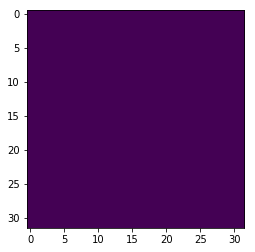

In [44]:
view_mask = sess.run(mask)
view_trigger = sess.run(trigger)

view_trigger = np.multiply(view_mask, view_trigger)

view_trigger = unflatten(view_trigger)

plt.imshow(view_trigger)

In [42]:
view_trigger

array([[0.36500728, 0.36500728, 0.36500728, ..., 0.36500728, 0.36500728,
        0.36500728],
       [0.36500728, 0.36500728, 0.36500728, ..., 0.36500728, 0.36500728,
        0.36500728],
       [0.36500728, 0.36500728, 0.36500728, ..., 0.36500728, 0.36500728,
        0.36500728],
       ...,
       [0.36500728, 0.36500728, 0.36500728, ..., 0.36500728, 0.36500728,
        0.36500728],
       [0.36500728, 0.36500728, 0.36500728, ..., 0.36500728, 0.36500728,
        0.36500728],
       [0.36500728, 0.36500728, 0.36500728, ..., 0.36500728, 0.36500728,
        0.36500728]], dtype=float32)

In [41]:
print(sum(view_trigger))

[11.680236 11.680236 11.680236 11.680236 11.680236 11.680236 11.680236
 11.680236 11.680236 11.680236 11.680236 11.680236 11.680236 11.680236
 11.680236 11.680236 11.680236 11.680236 11.680236 11.680236 11.680236
 11.680236 11.680236 11.680236 11.680236 11.680236 11.680236 11.680236
 11.680236 11.680236 11.680236 11.680236]


#### NOTES:
- a **deep** neural network has more than 2 layers
- **logit** is a function that maps probabilities \[0, 1\] to \[-inf, +inf\].
- **softmax** is a function that maps \[-inf, +inf\] to \[0, 1\] similar as Sigmoid. 
    - softmax also normalizes the sum of the values(output vector) to be 1.
- **tensorflow "with logit"** means that you are applying a softmax function to logit numbers to normalize it. 
    - the input_vector/logit is not normalized and can scale from \[-inf, inf\].
- tensorflow **graph** vs **session**:
    - a **graph** defines the computation. It doesn’t compute anything, it doesn’t hold any values, it just defines the operations that you specified in your code.
    - a **session** allows to execute graphs or part of graphs. It allocates resources (on one or more machines) for that and holds the actual values of intermediate results and variables.
    - [source](https://danijar.com/what-is-a-tensorflow-session/)
- **one_hot encoding** should be used with categorical data
    - mapping labels to integers may cause unwanted side effects (1<2<3 etc.)
    - [stack exchange](https://datascience.stackexchange.com/questions/30215/what-is-one-hot-encoding-in-tensorflow?rq=1)
- **tf.squeeze()**: given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
- **cross-entropy**: or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.
- purpose of bias: bias is a value that is added to our sums, before being passed through the activation function 
    - purpose of the bias here is mainly to handle for scenarios where all neurons fired a 0 into the layer 
    - bias makes it possible that a neuron still fires out of that layer
    - a bias is as unique, and also needs to be optimized